In [1]:

from google.colab import drive
import os
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("./drive/My Drive/AI_Colab/StyleTransfer")

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import vgg16
import cv2
import PIL.Image


In [4]:
!ls

data	     main.ipynb   styleTransfer.ipynb  vgg16.py
download.py  __pycache__  vgg16


In [0]:
model = vgg16.VGG16()

In [0]:
def load_image(filename):
    img = PIL.Image.open(filename)
    return np.float32(img)

def plot_image(img):
    img = np.clip(img, 0.0, 255.0)
    img = img.astype(np.uint8)
    display(PIL.Image.fromarray(img))

In [0]:
content_filename = 'data/content.jpg'
content_img = load_image(content_filename)
# plot_image(content_img)

In [0]:
def mean_square_error(a,b):
    return tf.reduce_mean(tf.square(a-b))

def gram_matrix(a):    
    shape = a.get_shape()
    reshape_tensor = tf.reshape(a, shape=[-1, int(shape[3])])
    gram_tensor = tf.matmul(tf.transpose(reshape_tensor), reshape_tensor)
    return gram_tensor
    

In [0]:
def content_loss(model, session, content_img, c_layer_ids):
    with model.graph.as_default():
        c_layers = model.get_layer_tensors(c_layer_ids)
        feed_dict = model.create_feed_dict(image=content_img)
        c_values = session.run(c_layers, feed_dict=feed_dict)
        c_loss = []
        for v, l in zip(c_values, c_layers):
            loss = mean_square_error(l, v)
            c_loss.append(loss)
        return tf.reduce_mean(c_loss)


def style_loss(model, session, style_img, s_layer_ids):
    with model.graph.as_default():
        s_layers = model.get_layer_tensors(s_layer_ids)
        gram_matrix_tensor = [gram_matrix(l) for l in s_layers]
        feed_dict = model.create_feed_dict(image=style_img)
        gram_matrix_values = session.run(gram_matrix_tensor, feed_dict=feed_dict)
        s_loss = []
        for v, l in zip(gram_matrix_values, gram_matrix_tensor):
            loss = mean_square_error(v,l)
            s_loss.append(loss)
        return tf.reduce_mean(s_loss)
    
def denoise_loss(input_):
    d_loss = tf.reduce_mean(tf.abs(input_[:,1:,:,:] - input_[:,:-1,:,:])) + \
            tf.reduce_mean(tf.abs(input_[:,:,1:,:] - input_[:,:,:-1,:]))
    return d_loss
        
    
def transfer(model, content_img, style_img,
             c_layer_ids, s_layer_ids, w_content=1.5, 
             w_style=10.0, w_denoise=0.3, iters= 60, step_size=10):
    img_result = np.random.rand(*content_img.shape) + 128
    session = tf.Session(graph = model.graph)

    c_loss = content_loss(model, session, content_img, c_layer_ids)
    s_loss = style_loss( model, session, style_img, s_layer_ids)
    d_loss = denoise_loss(model.input)
    with model.graph.as_default():
        adj_content = tf.Variable(1e-10, name='adj_content')
        adj_style = tf.Variable(1e-10, name='adj_style')
        adj_denoise = tf.Variable(1e-10, name='adj_denoise')

        session.run([adj_content.initializer,
                     adj_style.initializer,
                     adj_denoise.initializer])
 
        update_adj_content = adj_content.assign(1/(c_loss + 1e-10))
        update_adj_style = adj_style.assign(1/(s_loss + 1e-10))
        update_adj_denoise = adj_denoise.assign(1/(d_loss + 1e-10))

        total_loss = w_content * adj_content * c_loss +  w_denoise * adj_denoise * d_loss + w_style * adj_style * s_loss
        grad = tf.gradients(total_loss, model.input)
        run_list = [grad, update_adj_content, update_adj_style, update_adj_denoise]
        
        for i in range(iters):
            print(i)
            feed_dict = model.create_feed_dict(image=img_result)
            grad_value, _, _, _ = session.run(run_list, feed_dict=feed_dict)
            grad_value = np.squeeze(grad_value)
            grad_value = grad_value.reshape(img_result.shape)
            
            scale_step = step_size/(np.std(grad_value) + 1e-8)
            img_result -= grad_value*scale_step
            img_result = np.clip(img_result, 0.0, 255.0)
            if( i % 10 == 0):
                plot_image(img_result)
    return img_result
        
        



0


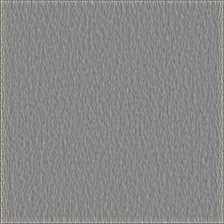

1
2
3
4
5
6
7
8
9
10


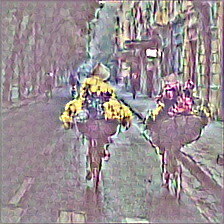

11
12
13
14
15
16
17
18
19
20


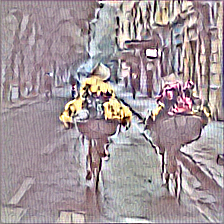

21
22
23
24
25
26
27
28
29
30


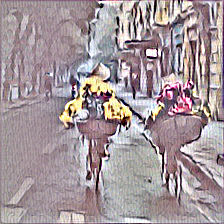

31
32
33
34
35
36
37
38
39
40


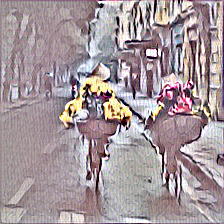

41
42
43
44
45
46
47
48
49
50


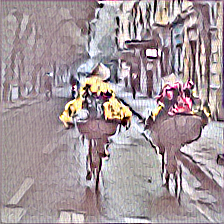

51
52
53
54
55
56
57
58
59


In [24]:
        
content_dir = 'data/content.jpg'
content_img = load_image(content_dir)
content_img = cv2.resize(content_img, (224,224))


style_dir = 'data/style.jpeg'
style_img = load_image(style_dir)
style_img = cv2.resize(style_img, (224,224))

c_layer_ids = [4]
s_layer_ids = range(13)
result_img = transfer(model, content_img, style_img, 
                      c_layer_ids, s_layer_ids, 
                      w_content=10, w_style=10.0, w_denoise=0.3, 
                      iters= 60, step_size=10)

In [0]:
def save_image(img, name):
    img = img[:,:, ::-1]
    cv2.imwrite(name, img)
    
save_image(result_img, "result.jpg")